# Assignment

**Create Panorama image**

**Instruction : This section you need to create 1 panorama from 3 pier images.**

In [1]:
#1st image : peir_1.jpg
!gdown "1Gstc-9xF_3s7jB6uwB4tHzsUVY2usv0k"

#2st image : peir_2.jpg
!gdown "1mPucyctY8YJOQlxzp3yZwM1NhMC--fPN"

#3st image : peir_3.jpg
!gdown "1qLRpmiTVx96DwAjGNP0580cb8yJ0GA44"

Downloading...
From: https://drive.google.com/uc?id=1Gstc-9xF_3s7jB6uwB4tHzsUVY2usv0k
To: /content/pier_1.JPG
100% 122k/122k [00:00<00:00, 9.45MB/s]
Downloading...
From: https://drive.google.com/uc?id=1mPucyctY8YJOQlxzp3yZwM1NhMC--fPN
To: /content/pier_2.JPG
100% 116k/116k [00:00<00:00, 46.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1qLRpmiTVx96DwAjGNP0580cb8yJ0GA44
To: /content/pier_3.JPG
100% 120k/120k [00:00<00:00, 39.7MB/s]


In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [11]:
def display_images(images):

    #Check that image is list type or not.
    if not isinstance(images, list):
        #If not list type
        figure(figsize=(12, 12))
        plt.imshow(cv2.cvtColor(images, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
        plt.axis('off')
        return

    n = len(images)
    cols = int(np.ceil(np.sqrt(n)))
    rows = int(np.ceil(n / cols))
    print("n = ",n)
    print("cols = ",cols)
    print("rows = ",rows)

    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    print("axes before: ",len(axes))
    axes = axes.flatten()  # Flatten the axes array for easier indexing
    print("axes after: ",len(axes))

    for i in range(n):
        axes[i].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
        axes[i].axis('off') #hide axis


    # Hide any unused subplots
    for j in range(i + 1, rows * cols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

In [12]:
pier1 = cv2.imread('pier_1.JPG')
pier2 = cv2.imread('pier_2.JPG')
pier3 = cv2.imread('pier_3.JPG')

n =  3
cols =  2
rows =  2
axes before:  2
axes after:  4


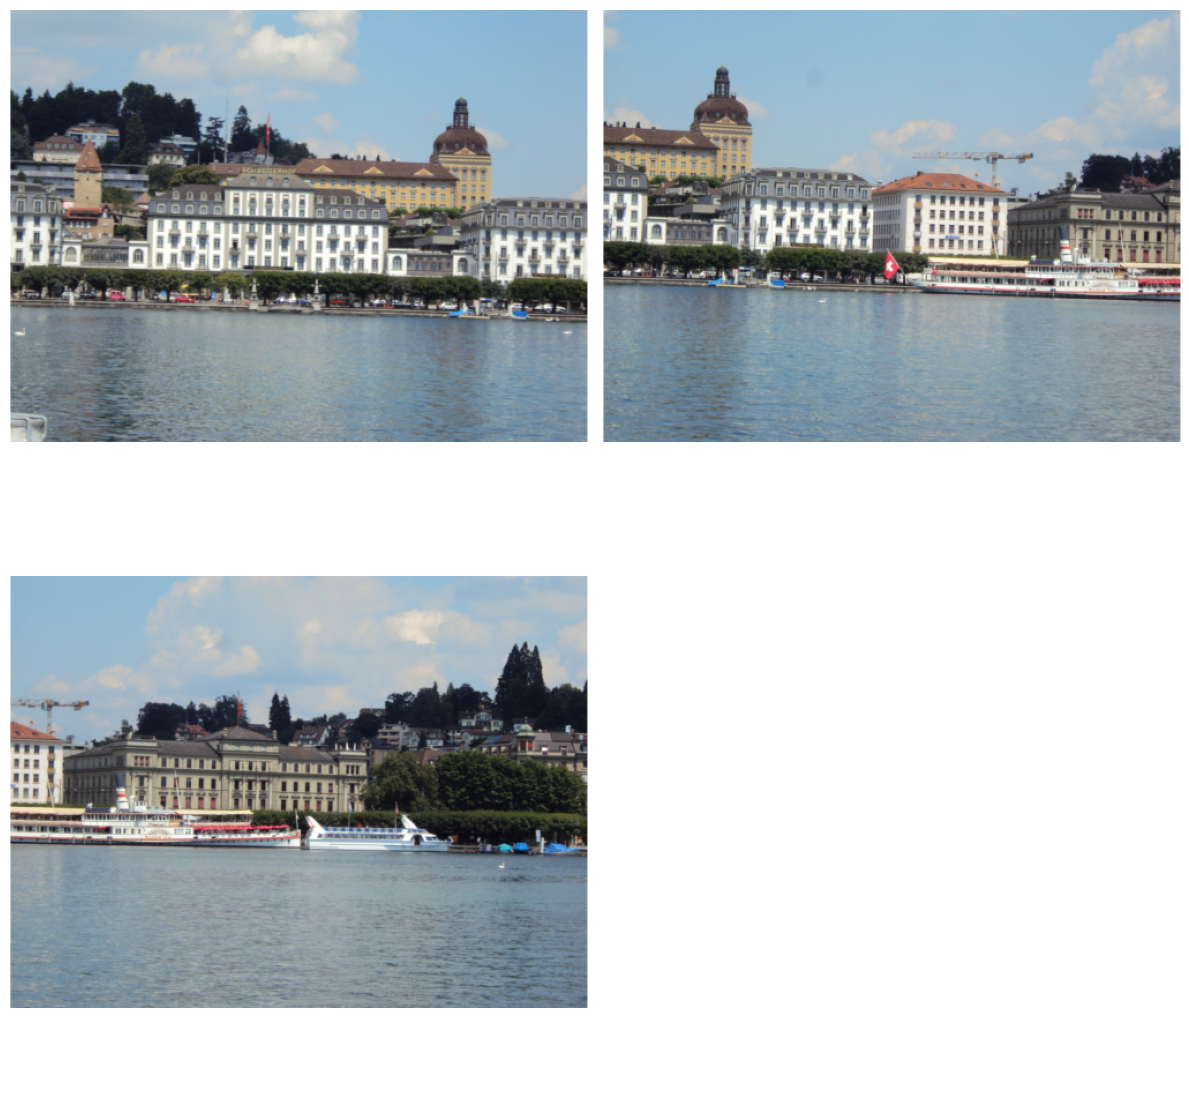

In [64]:
display_images([pier1,pier2,pier3])

In [71]:
def stitch_images(img1, img2):
    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append([m])


    src_pts = np.float32([ keypoints1[m[0].queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ keypoints2[m[0].trainIdx].pt for m in good_matches ]).reshape(-1,1,2)

    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    good_matches_ransac = [good_matches[i] for i in range(len(good_matches)) if mask[i]]

    limit = 50
    good_matches_ransac_top = sorted(good_matches_ransac, key = lambda x:x[0].distance)[:limit]

    selected_good_matches=good_matches_ransac_top
    src_pts = np.float32([ keypoints1[m[0].queryIdx].pt for m in selected_good_matches]).reshape(-1,1,2)
    dst_pts = np.float32([ keypoints2[m[0].trainIdx].pt for m in selected_good_matches]).reshape(-1,1,2)

    H, _ = cv2.findHomography(np.float32(dst_pts), np.float32(src_pts))

    result = blending_smoothing(img1, img2, H)
    result = np.uint8(result)
    return result

def create_mask(query_image, train_image, version):
        smoothing_window_percent = 0.10 # consider increasing or decreasing[0.00, 1.00]
        width_query_photo = query_image.shape[1]
        width_train_photo = train_image.shape[1]
        lowest_width = min(width_query_photo, width_train_photo)
        smoothing_window_size = max(100, min(smoothing_window_percent * lowest_width, 1000))

        height_query_photo = query_image.shape[0]
        height_panorama = height_query_photo
        width_panorama = width_query_photo + width_train_photo

        offset = int(smoothing_window_size / 2)
        barrier = query_image.shape[1] - int(smoothing_window_size / 2)
        mask = np.zeros((height_panorama, width_panorama))
        if version == "left_image":
            mask[:, barrier - offset : barrier + offset] = np.tile(
                np.linspace(1, 0, 2 * offset).T, (height_panorama, 1)
            )
            mask[:, : barrier - offset] = 1
        else:
            mask[:, barrier - offset : barrier + offset] = np.tile(
                np.linspace(0, 1, 2 * offset).T, (height_panorama, 1)
            )
            mask[:, barrier + offset :] = 1
        return cv2.merge([mask, mask, mask])

def blending_smoothing(query_image, train_image, homography_matrix):
        height_img1 = query_image.shape[0]
        width_img1 = query_image.shape[1]
        width_img2 = train_image.shape[1]
        height_panorama = height_img1
        width_panorama = width_img1 + width_img2

        panorama1 = np.zeros((height_panorama, width_panorama, 3))
        mask1 = create_mask(query_image, train_image, version="left_image")
        panorama1[0 : query_image.shape[0], 0 : query_image.shape[1], :] = query_image
        panorama1 *= mask1
        mask2 = create_mask(query_image, train_image, version="right_image")
        panorama2 = (
            cv2.warpPerspective(
                train_image, homography_matrix, (width_panorama, height_panorama)
            )
            * mask2
        )
        result = panorama1 + panorama2

        # remove extra blackspace
        rows, cols = np.where(result[:, :, 0] != 0)
        min_row, max_row = min(rows), max(rows) + 1
        min_col, max_col = min(cols), max(cols) + 1

        final_result = result[min_row:max_row, min_col:max_col, :]

        return final_result




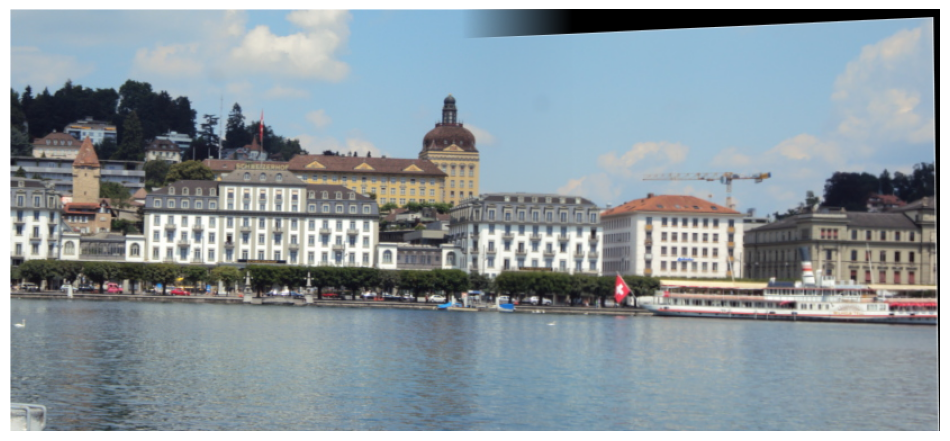

In [74]:
pano_12 = stitch_images(pier1, pier2)
display_images(pano_12)

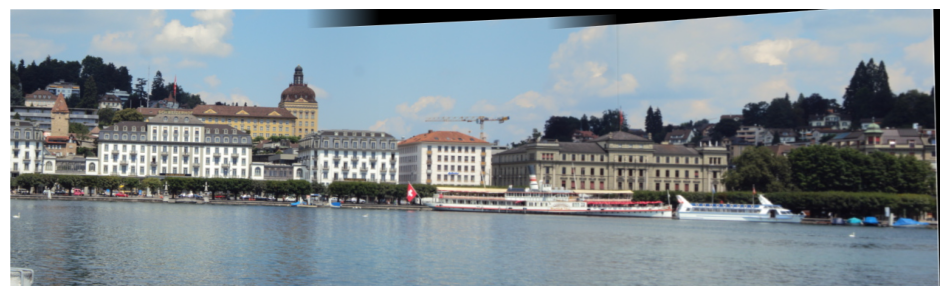

In [75]:
pano_123 = stitch_images(pano_12, pier3)
display_images(pano_123)